In [1]:
# Melakukan impor libraries yang diperlukan untuk membangun model dan prediksi data.
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as MSE
import optuna
from optuna.samplers import TPESampler
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
import random
import time
import datetime

In [2]:
# Mencatat waktu dimulainya keseluruhan program model dan prediksi data.
global_start_time = time.time()

In [3]:
# Menetapkan nilai seed untuk reproduksi model.
seed = 2021
def set_seed(seed = seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = str(seed)

set_seed()

In [4]:
# Menentukan indeks fold, kode penamaan program, banyak epoch, dan ukuran batch.
fold_index = 2
codename = '1_04_01_{}'.format(fold_index)
epochs = 128
batch_size = 64

In [5]:
# Menyusun data training.
df_train = pd.read_csv('../input/bdc-sd2021-train-tabular-data/train_gray.csv')
fake_train = pd.DataFrame(np.array(df_train).reshape((2305, 128, 128))[:, :, ::-1].reshape((2305, 128*128)))
fake_train.columns = df_train.columns
df_train = pd.concat([df_train, fake_train], ignore_index = True)
del fake_train

# Menyusun data testing.
df_test = pd.read_csv('../input/bdc-sd2021-test-tabular-data/test_gray.csv')

In [6]:
# Melakukan normalisasi pada data training.
scaler = MinMaxScaler(copy = False)
scaler.fit_transform(df_train.T)
df_train

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0.183857,0.139013,0.098655,0.116592,0.121076,0.103139,0.116592,0.094170,0.089686,0.076233,...,0.242152,0.089686,0.103139,0.121076,0.134529,0.156951,0.156951,0.156951,0.174888,0.152466
1,0.857868,0.857868,0.857868,0.857868,0.857868,0.857868,0.842640,0.827411,0.842640,0.827411,...,0.319797,0.294416,0.253807,0.208122,0.147208,0.116751,0.096447,0.065990,0.055838,0.040609
2,0.018182,0.013636,0.013636,0.018182,0.018182,0.018182,0.018182,0.018182,0.013636,0.018182,...,0.568182,0.559091,0.536364,0.518182,0.486364,0.436364,0.368182,0.254545,0.113636,0.045455
3,0.162500,0.162500,0.154167,0.154167,0.166667,0.187500,0.216667,0.254167,0.233333,0.183333,...,0.666667,0.675000,0.745833,0.887500,0.908333,0.900000,0.916667,0.945833,0.966667,0.966667
4,0.893023,0.860465,0.804651,0.879070,0.869767,0.637209,0.479070,0.269767,0.186047,0.186047,...,0.106977,0.032558,0.027907,0.018605,0.004651,0.000000,0.000000,0.004651,0.009302,0.018605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4605,0.090476,0.076190,0.095238,0.114286,0.090476,0.109524,0.076190,0.061905,0.052381,0.076190,...,0.157143,0.114286,0.133333,0.047619,0.061905,0.061905,0.052381,0.042857,0.042857,0.042857
4606,0.356828,0.370044,0.396476,0.409692,0.396476,0.422907,0.471366,0.515419,0.480176,0.436123,...,0.030837,0.035242,0.030837,0.026432,0.022026,0.017621,0.039648,0.026432,0.017621,0.035242
4607,0.306977,0.279070,0.339535,0.330233,0.320930,0.367442,0.367442,0.316279,0.283721,0.339535,...,0.060465,0.074419,0.065116,0.051163,0.051163,0.046512,0.083721,0.065116,0.055814,0.097674
4608,0.145000,0.240000,0.290000,0.295000,0.230000,0.170000,0.185000,0.200000,0.200000,0.230000,...,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.010000,0.010000,0.010000


In [7]:
# Melakukan normalisasi pada data testing.
scaler.fit_transform(df_test.T)
df_test

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0.095238,0.100000,0.100000,0.095238,0.095238,0.100000,0.109524,0.114286,0.119048,0.104762,...,0.347619,0.361905,0.314286,0.400000,0.419048,0.261905,0.233333,0.300000,0.266667,0.257143
1,0.061983,0.061983,0.061983,0.061983,0.061983,0.061983,0.061983,0.061983,0.066116,0.066116,...,0.417355,0.322314,0.285124,0.471074,0.508264,0.475207,0.541322,0.644628,0.611570,0.512397
2,0.531120,0.493776,0.485477,0.427386,0.402490,0.356846,0.340249,0.356846,0.336100,0.340249,...,0.190871,0.112033,0.062241,0.058091,0.074689,0.066390,0.058091,0.053942,0.045643,0.053942
3,0.796703,0.796703,0.791209,0.791209,0.796703,0.818681,0.818681,0.785714,0.763736,0.763736,...,0.961538,0.950549,0.950549,0.945055,0.939560,0.928571,0.923077,0.917582,0.906593,0.879121
4,0.222222,0.232804,0.232804,0.248677,0.253968,0.259259,0.248677,0.243386,0.243386,0.243386,...,0.619048,0.613757,0.608466,0.608466,0.613757,0.592593,0.566138,0.502646,0.470899,0.449735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,0.828571,0.844898,0.804082,0.824490,0.918367,0.963265,0.987755,0.959184,0.873469,0.722449,...,0.857143,0.848980,0.828571,0.832653,0.840816,0.840816,0.816327,0.820408,0.783673,0.767347
986,0.048780,0.065041,0.077236,0.105691,0.117886,0.121951,0.126016,0.069106,0.060976,0.052846,...,0.186992,0.207317,0.223577,0.239837,0.260163,0.284553,0.304878,0.321138,0.337398,0.357724
987,0.056872,0.056872,0.061611,0.061611,0.071090,0.056872,0.037915,0.023697,0.009479,0.018957,...,0.900474,0.890995,0.895735,0.900474,0.895735,0.895735,0.890995,0.890995,0.890995,0.890995
988,0.109244,0.155462,0.168067,0.121849,0.113445,0.088235,0.079832,0.084034,0.079832,0.067227,...,0.525210,0.281513,0.050420,0.033613,0.037815,0.033613,0.033613,0.042017,0.042017,0.042017


In [8]:
# Memunculkan target prediksi.
target_0 = pd.read_csv('../input/bdc-sd2021-data-tambahan/train_target_and_fold.csv')[['usia', 'fold']]
target_1 = pd.concat([target_0 for iteration in range(2)], ignore_index = True)
target_1

,usia,fold
0,27,3
1,27,3
2,27,3
3,24,0
4,24,0
...,...,...
4605,23,4
4606,23,4
4607,27,4
4608,27,4


In [9]:
# Melakukan penambahan data training yang berkaitan dengan posisi relatif fitur pada wajah.
df_train_1 = pd.read_csv('../input/bdc-sd2021-data-tambahan/train_facial_relative.csv')
fake_train_1 = df_train_1.copy()
fake_train_1['x_le'] = 1 - df_train_1['x_re']
fake_train_1['x_re'] = 1 - df_train_1['x_le']
fake_train_1['x_n'] = 1 - df_train_1['x_n']
fake_train_1['x_ml'] = 1 - df_train_1['x_mr']
fake_train_1['x_mr'] = 1 - df_train_1['x_ml']
fake_train_1[['sym_le_n', 'adj_le_n', 'sym_re_n', 'adj_re_n']] = df_train_1[['sym_re_n', 'adj_re_n', 'sym_le_n', 'adj_le_n']]
fake_train_1[['sym_le_ml', 'adj_le_ml', 'sym_re_mr', 'adj_re_mr']] = df_train_1[['sym_re_mr', 'adj_re_mr', 'sym_le_ml', 'adj_le_ml']]
fake_train_1[['sym_le_mr', 'adj_le_mr', 'sym_re_ml', 'adj_re_ml']] = df_train_1[['sym_re_ml', 'adj_re_ml', 'sym_le_mr', 'adj_le_mr']]
fake_train_1[['sym_n_ml', 'adj_n_ml', 'sym_n_mr', 'adj_n_mr']] = df_train_1[['sym_n_mr', 'adj_n_mr', 'sym_n_ml', 'adj_n_ml']]

df_train_1 = pd.concat([df_train_1, fake_train_1], ignore_index = True)
del fake_train_1

df_train_1

,x_le,y_le,x_re,y_re,x_n,y_n,x_ml,y_ml,x_mr,y_mr,...,adj_n_ml,sym_le_mr,adj_le_mr,sym_re_mr,adj_re_mr,sym_n_mr,adj_n_mr,sym_ml_mr,adj_ml_mr,abs_angle
0,0.204545,0.390411,0.698052,0.392694,0.405844,0.618721,0.194805,0.712329,0.733766,0.705479,...,0.249515,0.615908,0.693416,0.314818,0.446237,0.339205,0.350364,0.539005,0.539049,0.061566
1,0.179724,0.397351,0.589862,0.403974,0.290323,0.619205,0.202765,0.725166,0.635945,0.728477,...,0.171500,0.563722,0.648461,0.327759,0.453958,0.362484,0.377599,0.433192,0.433204,0.134023
2,0.195946,0.404878,0.662162,0.404878,0.378378,0.614634,0.202703,0.731707,0.682432,0.731707,...,0.239078,0.586077,0.664537,0.327457,0.453156,0.325814,0.344595,0.479730,0.479730,0.174672
3,0.266055,0.373239,0.715596,0.373239,0.440367,0.549296,0.238532,0.690141,0.724771,0.704225,...,0.272772,0.565660,0.629561,0.331113,0.431290,0.323865,0.348745,0.486442,0.486585,0.121842
4,0.244565,0.389764,0.695652,0.393701,0.413043,0.578740,0.217391,0.696850,0.706522,0.712598,...,0.254682,0.563583,0.641880,0.319083,0.440352,0.322564,0.346806,0.489384,0.489613,0.012195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4605,0.362934,0.401146,0.803089,0.383954,0.660232,0.616046,0.389961,0.759312,0.737452,0.753582,...,0.327708,0.530242,0.629355,0.364131,0.487068,0.162752,0.207921,0.347538,0.347576,0.540420
4606,0.232323,0.386256,0.744108,0.398104,0.515152,0.649289,0.313131,0.772512,0.717172,0.779621,...,0.274054,0.612584,0.719783,0.387194,0.549482,0.236635,0.267332,0.404103,0.404167,0.552494
4607,0.274869,0.400372,0.759162,0.396648,0.523560,0.616387,0.324607,0.780261,0.685864,0.780261,...,0.304386,0.562206,0.678031,0.386895,0.539038,0.230645,0.281800,0.361257,0.361257,0.162489
4608,0.323887,0.405836,0.801619,0.413793,0.668016,0.631300,0.425101,0.801061,0.785425,0.814324,...,0.370196,0.602490,0.749939,0.395557,0.603456,0.206407,0.284469,0.360568,0.360892,0.456213


In [10]:
# Melakukan penambahan data testing yang berkaitan dengan posisi relatif fitur pada wajah.
df_test_1 = pd.read_csv('../input/bdc-sd2021-data-tambahan/test_facial_relative.csv')
df_test_1

,x_le,y_le,x_re,y_re,x_n,y_n,x_ml,y_ml,x_mr,y_mr,...,adj_n_ml,sym_le_mr,adj_le_mr,sym_re_mr,adj_re_mr,sym_n_mr,adj_n_mr,sym_ml_mr,adj_ml_mr,abs_angle
0,0.291209,0.333333,0.758242,0.338028,0.521978,0.516432,0.296703,0.732394,0.730769,0.737089,...,0.338570,0.596852,0.645365,0.400006,0.467840,0.303782,0.332088,0.434091,0.434101,0.070471
1,0.281690,0.405128,0.753521,0.394872,0.549296,0.625641,0.260563,0.723077,0.746479,0.707692,...,0.318229,0.554593,0.623428,0.312900,0.429635,0.213573,0.227106,0.486159,0.486375,0.029403
2,0.214533,0.403023,0.660900,0.397985,0.366782,0.612091,0.235294,0.727960,0.692042,0.722922,...,0.206456,0.574761,0.648943,0.326426,0.447452,0.343624,0.359129,0.456775,0.456800,0.022553
3,0.365517,0.391753,0.779310,0.402062,0.648276,0.597938,0.393103,0.773196,0.758621,0.757732,...,0.346547,0.537095,0.627927,0.356271,0.476312,0.194191,0.240590,0.365844,0.366102,0.064427
4,0.265625,0.381323,0.734375,0.369650,0.500000,0.603113,0.296875,0.747082,0.718750,0.735409,...,0.279993,0.575064,0.655712,0.366092,0.489833,0.255644,0.281443,0.422036,0.422164,0.044914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,0.356364,0.398892,0.821818,0.398892,0.650909,0.617729,0.374545,0.739612,0.785455,0.736842,...,0.319338,0.546195,0.617197,0.339901,0.445124,0.179696,0.206282,0.410918,0.410925,0.124355
986,0.274725,0.380952,0.758242,0.373016,0.582418,0.563492,0.362637,0.777778,0.747253,0.753968,...,0.369237,0.602016,0.700027,0.381111,0.527587,0.251896,0.311010,0.385352,0.386026,0.047583
987,0.289855,0.373737,0.753623,0.383838,0.521739,0.585859,0.275362,0.737374,0.724638,0.747475,...,0.328573,0.573337,0.690348,0.364790,0.522544,0.259399,0.308120,0.449389,0.449509,0.031240
988,0.142857,0.338403,0.614286,0.338403,0.319048,0.593156,0.200000,0.779468,0.557143,0.779468,...,0.261948,0.605120,0.690476,0.444751,0.555329,0.302327,0.333367,0.357143,0.357143,0.020199


In [11]:
# Menyusun indeks untuk data training dan melakukan shuffle.
train_index = list(target_1[target_1['fold'] != fold_index].index)
random.seed(seed)
random.shuffle(train_index)

# Menyusun indeks untuk data validasi.
valid_index = list(target_0[target_0['fold'] == fold_index].index)

# Memisahkan data validasi dari data training, serta menginisiasi data testing.
X_train = df_train.iloc[train_index]
X_valid = df_train.iloc[valid_index]
X_test = df_test.copy()

X_train_1 = df_train_1.iloc[train_index]
X_valid_1 = df_train_1.iloc[valid_index]
X_test_1 = df_test_1.copy()

# Melakukan reduksi dimensi dengan menggunakan PCA.
pca = PCA(0.95)
X_train = pd.DataFrame(pca.fit_transform(X_train))
X_valid = pd.DataFrame(pca.transform(X_valid))
X_test = pd.DataFrame(pca.transform(X_test))

pca = PCA(0.95)
X_train_1 = pd.DataFrame(pca.fit_transform(X_train_1))
X_valid_1 = pd.DataFrame(pca.transform(X_valid_1))
X_test_1 = pd.DataFrame(pca.transform(X_test_1))

# Menggabungkan informasi pada data training, validasi, dan testing.
X_train = pd.concat([X_train, X_train_1], axis = 1, ignore_index = True)
X_valid = pd.concat([X_valid, X_valid_1], axis = 1, ignore_index = True)
X_test = pd.concat([X_test, X_test_1], axis = 1, ignore_index = True)
del X_train_1, X_valid_1, X_test_1

# Mengubah ukuran data agar sesuai dengan input yang diharapkan oleh model.
X_train = X_train.values.reshape(-1, X_train.shape[1], 1).astype('float64')
X_valid = X_valid.values.reshape(-1, X_valid.shape[1], 1).astype('float64')
X_test = X_test.values.reshape(-1, X_test.shape[1], 1).astype('float64')

# Memisahkan target validasi dari target training.
y_train = target_1.iloc[train_index, 0].astype('int64')
y_valid = target_0.iloc[valid_index, 0].astype('int64')

# Membuang informasi yang sudah tidak diperlukan lagi.
del df_train, df_test, df_train_1, df_test_1, pca, target_0, target_1, train_index, valid_index

In [12]:
# Mendefinisikan fungsi untuk mencari parameter terbaik dengan nilai error terkecil.
def create_model(trial):
    n_layers = trial.suggest_int('n_layers', 2, 5)
    weight_decay = trial.suggest_float('weight_decay', 1e-10, 1e-3, log = True)
    dropout = trial.suggest_float('dropout', 0.2, 0.5, log = True)
    model = Sequential()
    for i in range(n_layers-1):
        num_hidden = trial.suggest_int('n_units_l{}'.format(i), 32, 256, log = True)
        if i:
            model.add(Dense(num_hidden,
                            activation = 'relu',
                            kernel_regularizer = regularizers.l2(weight_decay)))
            model.add(Dropout(dropout))
        else:
            model.add(Dense(num_hidden,
                            activation = 'relu',
                            kernel_regularizer = regularizers.l2(weight_decay),
                            input_shape = (X_train.shape[1], 1)))
    model.add(Flatten())
    num_hidden = trial.suggest_int('n_units_l{}'.format(n_layers-1), 32, 256, log = True)
    model.add(Dense(num_hidden,
                    activation = 'relu',
                    kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Dense(1,
                    activation = 'linear',
                    kernel_regularizer = regularizers.l2(weight_decay)))
    return model

def create_optimizer(trial):
    kwargs = {}
    optimizer_options = ['RMSprop', 'Adam', 'SGD']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    if optimizer_selected == 'RMSprop':
        kwargs['learning_rate'] = trial.suggest_float(
            'rmsprop_learning_rate', 1e-5, 1e-1, log=True)
        kwargs['decay'] = trial.suggest_float('rmsprop_decay', 0.85, 0.99)
        kwargs['momentum'] = trial.suggest_float('rmsprop_momentum', 1e-5, 1e-1, log = True)
    elif optimizer_selected == 'Adam':
        kwargs['learning_rate'] = trial.suggest_float('adam_learning_rate', 1e-5, 1e-1, log = True)
    elif optimizer_selected == 'SGD':
        kwargs['learning_rate'] = trial.suggest_float(
            'sgd_opt_learning_rate', 1e-5, 1e-1, log=True)
        kwargs['momentum'] = trial.suggest_float('sgd_opt_momentum', 1e-5, 1e-1, log = True)
    
    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

def objective(trial):
    model = create_model(trial)
    optimizer = create_optimizer(trial)
    model.compile(optimizer = optimizer,
                  loss = 'mean_squared_error',
                  metrics = ['mse'])
    set_seed()
    history = model.fit(X_train, y_train,
                        epochs = 3,
                        validation_data = (X_valid, y_valid),
                        verbose = 2,
                        steps_per_epoch = X_train.shape[0] // batch_size)
    y_valid_pred = model.predict(X_valid)
    try:
        mse = MSE(y_valid, y_valid_pred)
    except ValueError:
        mse = 1e+32
    return mse

In [13]:
# Mencari hyperparameters terbaik.
try:
    study = optuna.create_study(sampler = TPESampler(seed = seed), direction = 'minimize')
    study.optimize(objective, n_trials = 50)
except ValueError:
    pass

[I 2021-11-04 11:16:24,563] A new study created in memory with name: no-name-048c9744-a5ed-441a-a450-731b3f43e3c9

User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIN

Epoch 1/3
57/57 - 6s - loss: 634.3820 - mse: 634.3783 - val_loss: 430.9827 - val_mse: 430.9791
Epoch 2/3
57/57 - 5s - loss: 124.5637 - mse: 124.5601 - val_loss: 38.0582 - val_mse: 38.0546
Epoch 3/3
57/57 - 4s - loss: 39.8494 - mse: 39.8458 - val_loss: 36.3946 - val_mse: 36.3910


[I 2021-11-04 11:16:40,504] Trial 0 finished with value: 36.39095615456834 and parameters: {'n_layers': 4, 'weight_decay': 1.3601459990500093e-05, 'dropout': 0.22715517141780636, 'n_units_l0': 61, 'n_units_l1': 255, 'n_units_l2': 41, 'n_units_l3': 46, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 2.4410551066709827e-05, 'sgd_opt_momentum': 1.7150829926878746e-05}. Best is trial 0 with value: 36.39095615456834.


Epoch 1/3
57/57 - 10s - loss: 249.3298 - mse: 249.3288 - val_loss: 37.6007 - val_mse: 37.5996
Epoch 2/3
57/57 - 9s - loss: 36.3569 - mse: 36.3557 - val_loss: 34.2951 - val_mse: 34.2940
Epoch 3/3
57/57 - 9s - loss: 33.9318 - mse: 33.9306 - val_loss: 33.0318 - val_mse: 33.0306


[I 2021-11-04 11:17:09,180] Trial 1 finished with value: 33.03063651834235 and parameters: {'n_layers': 5, 'weight_decay': 2.069674778352553e-06, 'dropout': 0.2165227444547113, 'n_units_l0': 102, 'n_units_l1': 115, 'n_units_l2': 238, 'n_units_l3': 105, 'n_units_l4': 69, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 6.0309245793449296e-05, 'sgd_opt_momentum': 0.0021618027516387694}. Best is trial 1 with value: 33.03063651834235.


Epoch 1/3
57/57 - 3s - loss: 76.0461 - mse: 76.0460 - val_loss: 32.9636 - val_mse: 32.9634
Epoch 2/3
57/57 - 2s - loss: 29.9909 - mse: 29.9907 - val_loss: 31.5774 - val_mse: 31.5772
Epoch 3/3
57/57 - 2s - loss: 27.7061 - mse: 27.7059 - val_loss: 28.2552 - val_mse: 28.2550


[I 2021-11-04 11:17:16,742] Trial 2 finished with value: 28.254984416565467 and parameters: {'n_layers': 3, 'weight_decay': 4.2140608469491625e-07, 'dropout': 0.425181023662834, 'n_units_l0': 146, 'n_units_l1': 36, 'n_units_l2': 129, 'optimizer': 'Adam', 'adam_learning_rate': 0.0029509089780652155}. Best is trial 2 with value: 28.254984416565467.


Epoch 1/3
57/57 - 7s - loss: nan - mse: 124020365769740924768747520.0000 - val_loss: nan - val_mse: 244555097469420505661440.0000
Epoch 2/3
57/57 - 6s - loss: nan - mse: 122488938694019769171968.0000 - val_loss: nan - val_mse: 47678595945055282790400.0000
Epoch 3/3
57/57 - 6s - loss: nan - mse: 23880523923516590915584.0000 - val_loss: nan - val_mse: 9295447082341259804672.0000


[I 2021-11-04 11:17:36,465] Trial 3 finished with value: 9.295445977134576e+21 and parameters: {'n_layers': 4, 'weight_decay': 1.280797128821542e-08, 'dropout': 0.4445600696908863, 'n_units_l0': 108, 'n_units_l1': 247, 'n_units_l2': 80, 'n_units_l3': 41, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.006855869932485577, 'sgd_opt_momentum': 0.03652763447965056}. Best is trial 2 with value: 28.254984416565467.


Epoch 1/3
57/57 - 4s - loss: 153.9311 - mse: 153.9304 - val_loss: 34.7028 - val_mse: 34.7020
Epoch 2/3
57/57 - 4s - loss: 35.0141 - mse: 35.0133 - val_loss: 33.9452 - val_mse: 33.9444
Epoch 3/3
57/57 - 3s - loss: 32.6712 - mse: 32.6704 - val_loss: 36.2151 - val_mse: 36.2144


[I 2021-11-04 11:17:47,399] Trial 4 finished with value: 36.214382642256304 and parameters: {'n_layers': 4, 'weight_decay': 2.869521426120942e-06, 'dropout': 0.2736582989224417, 'n_units_l0': 177, 'n_units_l1': 60, 'n_units_l2': 60, 'n_units_l3': 48, 'optimizer': 'Adam', 'adam_learning_rate': 0.0003587550277569686}. Best is trial 2 with value: 28.254984416565467.


Epoch 1/3
57/57 - 5s - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/3
57/57 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/3
57/57 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan


[I 2021-11-04 11:18:01,955] Trial 5 finished with value: 1e+32 and parameters: {'n_layers': 4, 'weight_decay': 8.671491605192508e-05, 'dropout': 0.2120474687506201, 'n_units_l0': 75, 'n_units_l1': 63, 'n_units_l2': 143, 'n_units_l3': 85, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.012820573397259222, 'sgd_opt_momentum': 0.01219735525440408}. Best is trial 2 with value: 28.254984416565467.


Epoch 1/3
57/57 - 2s - loss: 98.3330 - mse: 98.3328 - val_loss: 54.3417 - val_mse: 54.3415
Epoch 2/3
57/57 - 1s - loss: 48.3332 - mse: 48.3330 - val_loss: 44.3379 - val_mse: 44.3377
Epoch 3/3
57/57 - 1s - loss: 43.4031 - mse: 43.4028 - val_loss: 41.6493 - val_mse: 41.6491


[I 2021-11-04 11:18:05,507] Trial 6 finished with value: 41.64906302287618 and parameters: {'n_layers': 2, 'weight_decay': 1.4490033299339797e-06, 'dropout': 0.4134236878013778, 'n_units_l0': 56, 'n_units_l1': 69, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0004666904757351211, 'rmsprop_decay': 0.894925822839254, 'rmsprop_momentum': 0.000308450498248823}. Best is trial 2 with value: 28.254984416565467.


Epoch 1/3
57/57 - 4s - loss: 53890.2109 - mse: 53890.2070 - val_loss: 105.8944 - val_mse: 105.8758
Epoch 2/3
57/57 - 3s - loss: 122.9632 - mse: 122.9446 - val_loss: 77.6858 - val_mse: 77.6672
Epoch 3/3
57/57 - 4s - loss: 93.8504 - mse: 93.8319 - val_loss: 58.3081 - val_mse: 58.2896


[I 2021-11-04 11:18:17,068] Trial 7 finished with value: 58.2895667388164 and parameters: {'n_layers': 3, 'weight_decay': 5.713328696681321e-06, 'dropout': 0.3407865362809055, 'n_units_l0': 241, 'n_units_l1': 75, 'n_units_l2': 63, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.019638650422524002, 'rmsprop_decay': 0.9279674621367233, 'rmsprop_momentum': 0.007481765717358807}. Best is trial 2 with value: 28.254984416565467.


Epoch 1/3
57/57 - 6s - loss: 352859.6562 - mse: 352859.6562 - val_loss: 360.6382 - val_mse: 360.6376
Epoch 2/3
57/57 - 5s - loss: 56.1614 - mse: 56.1607 - val_loss: 486.1512 - val_mse: 486.1505
Epoch 3/3
57/57 - 5s - loss: 49.5775 - mse: 49.5767 - val_loss: 473.2077 - val_mse: 473.2070


[I 2021-11-04 11:18:33,479] Trial 8 finished with value: 473.2069585497242 and parameters: {'n_layers': 5, 'weight_decay': 2.9653117862224153e-07, 'dropout': 0.3197493177048565, 'n_units_l0': 123, 'n_units_l1': 65, 'n_units_l2': 116, 'n_units_l3': 83, 'n_units_l4': 41, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.019054962911205356, 'rmsprop_decay': 0.874518227528278, 'rmsprop_momentum': 8.371297680962848e-05}. Best is trial 2 with value: 28.254984416565467.


Epoch 1/3
57/57 - 10s - loss: 3447.1152 - mse: 3447.0938 - val_loss: 44.8890 - val_mse: 44.8677
Epoch 2/3
57/57 - 9s - loss: 47.1135 - mse: 47.0922 - val_loss: 51.3701 - val_mse: 51.3488
Epoch 3/3
57/57 - 9s - loss: 44.0832 - mse: 44.0618 - val_loss: 50.1709 - val_mse: 50.1496


[I 2021-11-04 11:19:02,953] Trial 9 finished with value: 50.14955840551965 and parameters: {'n_layers': 4, 'weight_decay': 1.0556840099451229e-05, 'dropout': 0.22909938508654398, 'n_units_l0': 72, 'n_units_l1': 170, 'n_units_l2': 172, 'n_units_l3': 167, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.005553572385099785, 'rmsprop_decay': 0.9526963318618572, 'rmsprop_momentum': 3.908613352528237e-05}. Best is trial 2 with value: 28.254984416565467.


Epoch 1/3
57/57 - 1s - loss: 2770.6665 - mse: 2770.6663 - val_loss: 649.1117 - val_mse: 649.1108
Epoch 2/3
57/57 - 0s - loss: 596.0320 - mse: 596.0311 - val_loss: 535.2243 - val_mse: 535.2233
Epoch 3/3
57/57 - 1s - loss: 482.2611 - mse: 482.2599 - val_loss: 424.8442 - val_mse: 424.8432


[I 2021-11-04 11:19:05,461] Trial 10 finished with value: 424.8432315449747 and parameters: {'n_layers': 2, 'weight_decay': 1.5303673965817338e-08, 'dropout': 0.36337622618058174, 'n_units_l0': 37, 'n_units_l1': 38, 'optimizer': 'Adam', 'adam_learning_rate': 0.07687620678695332}. Best is trial 2 with value: 28.254984416565467.


Epoch 1/3
57/57 - 18s - loss: 1651.3342 - mse: 1640.5842 - val_loss: 709.2704 - val_mse: 696.6928
Epoch 2/3
57/57 - 15s - loss: 422.3993 - mse: 411.1902 - val_loss: 42.3622 - val_mse: 32.2718
Epoch 3/3
57/57 - 16s - loss: 43.1872 - mse: 33.8785 - val_loss: 37.1302 - val_mse: 28.5459


[I 2021-11-04 11:19:54,851] Trial 11 finished with value: 28.545921175968235 and parameters: {'n_layers': 5, 'weight_decay': 0.0008338016434700748, 'dropout': 0.4953827096246268, 'n_units_l0': 141, 'n_units_l1': 121, 'n_units_l2': 253, 'n_units_l3': 245, 'n_units_l4': 142, 'optimizer': 'Adam', 'adam_learning_rate': 0.008983185806335612}. Best is trial 2 with value: 28.254984416565467.


Epoch 1/3
57/57 - 3s - loss: 57.6600 - mse: 56.3507 - val_loss: 31.6973 - val_mse: 30.2483
Epoch 2/3
57/57 - 2s - loss: 29.4225 - mse: 28.1324 - val_loss: 30.8941 - val_mse: 29.7353
Epoch 3/3
57/57 - 2s - loss: 31.2268 - mse: 30.1410 - val_loss: 30.5199 - val_mse: 29.4981


[I 2021-11-04 11:20:03,228] Trial 12 finished with value: 29.49806306796871 and parameters: {'n_layers': 3, 'weight_decay': 0.000695990869779388, 'dropout': 0.4909028434074908, 'n_units_l0': 158, 'n_units_l1': 35, 'n_units_l2': 249, 'optimizer': 'Adam', 'adam_learning_rate': 0.00755110127673275}. Best is trial 2 with value: 28.254984416565467.


Epoch 1/3
57/57 - 6s - loss: 50.3094 - mse: 50.3094 - val_loss: 36.1515 - val_mse: 36.1515
Epoch 2/3
57/57 - 5s - loss: 28.3009 - mse: 28.3009 - val_loss: 28.7501 - val_mse: 28.7501
Epoch 3/3
57/57 - 5s - loss: 26.2831 - mse: 26.2831 - val_loss: 29.8600 - val_mse: 29.8600


[I 2021-11-04 11:20:18,524] Trial 13 finished with value: 29.86000111848165 and parameters: {'n_layers': 3, 'weight_decay': 2.2300489272818375e-10, 'dropout': 0.4065930680741262, 'n_units_l0': 157, 'n_units_l1': 112, 'n_units_l2': 165, 'optimizer': 'Adam', 'adam_learning_rate': 0.00444376159519675}. Best is trial 2 with value: 28.254984416565467.


Epoch 1/3
57/57 - 18s - loss: 500.6820 - mse: 499.9070 - val_loss: 429.3051 - val_mse: 428.5290
Epoch 2/3
57/57 - 16s - loss: 135.7867 - mse: 135.0086 - val_loss: 178.5393 - val_mse: 177.7594
Epoch 3/3
57/57 - 16s - loss: 41.0178 - mse: 40.2377 - val_loss: 128.8468 - val_mse: 128.0672


[I 2021-11-04 11:21:08,766] Trial 14 finished with value: 128.06719664654884 and parameters: {'n_layers': 5, 'weight_decay': 0.0008458907912218102, 'dropout': 0.49894630341746804, 'n_units_l0': 226, 'n_units_l1': 142, 'n_units_l2': 101, 'n_units_l3': 247, 'n_units_l4': 239, 'optimizer': 'Adam', 'adam_learning_rate': 1.1372062448678147e-05}. Best is trial 2 with value: 28.254984416565467.


Epoch 1/3
57/57 - 3s - loss: 80.9233 - mse: 80.9232 - val_loss: 35.4760 - val_mse: 35.4760
Epoch 2/3
57/57 - 2s - loss: 33.3580 - mse: 33.3579 - val_loss: 31.8423 - val_mse: 31.8422
Epoch 3/3
57/57 - 2s - loss: 27.5976 - mse: 27.5976 - val_loss: 29.3794 - val_mse: 29.3793


[I 2021-11-04 11:21:17,369] Trial 15 finished with value: 29.379326810046393 and parameters: {'n_layers': 3, 'weight_decay': 8.338686452279643e-08, 'dropout': 0.388802369072987, 'n_units_l0': 137, 'n_units_l1': 46, 'n_units_l2': 196, 'optimizer': 'Adam', 'adam_learning_rate': 0.0013696260166765222}. Best is trial 2 with value: 28.254984416565467.


Epoch 1/3
57/57 - 4s - loss: 2867.4824 - mse: 2867.4824 - val_loss: 689.4162 - val_mse: 689.4162
Epoch 2/3
57/57 - 3s - loss: 673.1593 - mse: 673.1593 - val_loss: 650.2180 - val_mse: 650.2180
Epoch 3/3
57/57 - 3s - loss: 631.3121 - mse: 631.3121 - val_loss: 606.5437 - val_mse: 606.5437


[I 2021-11-04 11:21:26,852] Trial 16 finished with value: 606.5436673768583 and parameters: {'n_layers': 2, 'weight_decay': 1.9772332223061944e-10, 'dropout': 0.4426731258175413, 'n_units_l0': 188, 'n_units_l1': 92, 'optimizer': 'Adam', 'adam_learning_rate': 0.02394270393204498}. Best is trial 2 with value: 28.254984416565467.


Epoch 1/3
57/57 - 13s - loss: 82.5312 - mse: 82.4750 - val_loss: 57.8815 - val_mse: 57.8249
Epoch 2/3
57/57 - 11s - loss: 34.8612 - mse: 34.8049 - val_loss: 55.2454 - val_mse: 55.1890
Epoch 3/3
57/57 - 11s - loss: 29.5894 - mse: 29.5323 - val_loss: 43.6965 - val_mse: 43.6386


[I 2021-11-04 11:22:02,756] Trial 17 finished with value: 43.638649585545885 and parameters: {'n_layers': 5, 'weight_decay': 8.216996498690948e-05, 'dropout': 0.28196079728961937, 'n_units_l0': 86, 'n_units_l1': 48, 'n_units_l2': 128, 'n_units_l3': 256, 'n_units_l4': 170, 'optimizer': 'Adam', 'adam_learning_rate': 0.00039066303299003456}. Best is trial 2 with value: 28.254984416565467.


Epoch 1/3
57/57 - 5s - loss: 61.6411 - mse: 61.6411 - val_loss: 32.8593 - val_mse: 32.8593
Epoch 2/3
57/57 - 4s - loss: 27.6336 - mse: 27.6336 - val_loss: 28.3325 - val_mse: 28.3325
Epoch 3/3
57/57 - 4s - loss: 26.4130 - mse: 26.4130 - val_loss: 29.1114 - val_mse: 29.1114


[I 2021-11-04 11:22:15,651] Trial 18 finished with value: 29.111418623157356 and parameters: {'n_layers': 3, 'weight_decay': 2.054742568659157e-09, 'dropout': 0.45710366263024144, 'n_units_l0': 126, 'n_units_l1': 170, 'n_units_l2': 33, 'optimizer': 'Adam', 'adam_learning_rate': 0.003201632483320692}. Best is trial 2 with value: 28.254984416565467.


Epoch 1/3
57/57 - 4s - loss: 2140.1375 - mse: 2135.7104 - val_loss: 693.2656 - val_mse: 687.5241
Epoch 2/3
57/57 - 3s - loss: 676.6662 - mse: 671.1623 - val_loss: 653.5881 - val_mse: 648.3418
Epoch 3/3
57/57 - 3s - loss: 634.9263 - mse: 629.9004 - val_loss: 610.5805 - val_mse: 605.7706


[I 2021-11-04 11:22:26,671] Trial 19 finished with value: 605.7706593376925 and parameters: {'n_layers': 2, 'weight_decay': 9.461140346895783e-05, 'dropout': 0.37602704313862817, 'n_units_l0': 202, 'n_units_l1': 98, 'optimizer': 'Adam', 'adam_learning_rate': 0.021103643524652636}. Best is trial 2 with value: 28.254984416565467.


Epoch 1/3
57/57 - 9s - loss: 196.6569 - mse: 196.6567 - val_loss: 70.2782 - val_mse: 70.2780
Epoch 2/3
57/57 - 7s - loss: 38.7361 - mse: 38.7359 - val_loss: 56.6035 - val_mse: 56.6033
Epoch 3/3
57/57 - 7s - loss: 36.4752 - mse: 36.4750 - val_loss: 55.7984 - val_mse: 55.7982


[I 2021-11-04 11:22:50,632] Trial 20 finished with value: 55.798253132713306 and parameters: {'n_layers': 5, 'weight_decay': 3.675608617804447e-07, 'dropout': 0.2758830291760725, 'n_units_l0': 34, 'n_units_l1': 140, 'n_units_l2': 87, 'n_units_l3': 144, 'n_units_l4': 113, 'optimizer': 'Adam', 'adam_learning_rate': 9.596974441162018e-05}. Best is trial 2 with value: 28.254984416565467.


Epoch 1/3
57/57 - 5s - loss: 81.7442 - mse: 81.7442 - val_loss: 34.3258 - val_mse: 34.3258
Epoch 2/3
57/57 - 4s - loss: 31.2114 - mse: 31.2114 - val_loss: 34.6698 - val_mse: 34.6698
Epoch 3/3
57/57 - 5s - loss: 27.0908 - mse: 27.0908 - val_loss: 29.7779 - val_mse: 29.7779


[I 2021-11-04 11:23:06,018] Trial 21 finished with value: 29.777889398461728 and parameters: {'n_layers': 3, 'weight_decay': 3.1732510618198037e-09, 'dropout': 0.452178879146484, 'n_units_l0': 130, 'n_units_l1': 197, 'n_units_l2': 33, 'optimizer': 'Adam', 'adam_learning_rate': 0.002316274151803358}. Best is trial 2 with value: 28.254984416565467.


Epoch 1/3
57/57 - 5s - loss: 138.7737 - mse: 138.7737 - val_loss: 28.9294 - val_mse: 28.9294
Epoch 2/3
57/57 - 4s - loss: 27.7768 - mse: 27.7767 - val_loss: 31.2142 - val_mse: 31.2142
Epoch 3/3
57/57 - 4s - loss: 27.5862 - mse: 27.5862 - val_loss: 27.9788 - val_mse: 27.9788


[I 2021-11-04 11:23:19,851] Trial 22 finished with value: 27.978829375675037 and parameters: {'n_layers': 3, 'weight_decay': 2.5708886545439426e-09, 'dropout': 0.4727970804211236, 'n_units_l0': 107, 'n_units_l1': 179, 'n_units_l2': 52, 'optimizer': 'Adam', 'adam_learning_rate': 0.009678567808334761}. Best is trial 22 with value: 27.978829375675037.


Epoch 1/3
57/57 - 4s - loss: 170.2288 - mse: 170.2288 - val_loss: 28.2349 - val_mse: 28.2349
Epoch 2/3
57/57 - 3s - loss: 29.2907 - mse: 29.2907 - val_loss: 32.4857 - val_mse: 32.4857
Epoch 3/3
57/57 - 3s - loss: 29.5218 - mse: 29.5218 - val_loss: 28.0499 - val_mse: 28.0499


[I 2021-11-04 11:23:30,575] Trial 23 finished with value: 28.049881821066517 and parameters: {'n_layers': 3, 'weight_decay': 1.059997296351158e-09, 'dropout': 0.4914789815861243, 'n_units_l0': 93, 'n_units_l1': 131, 'n_units_l2': 53, 'optimizer': 'Adam', 'adam_learning_rate': 0.01300293140183376}. Best is trial 22 with value: 27.978829375675037.


Epoch 1/3
57/57 - 5s - loss: 9193.4033 - mse: 9193.4033 - val_loss: 27.8859 - val_mse: 27.8858
Epoch 2/3
57/57 - 4s - loss: 28.2492 - mse: 28.2491 - val_loss: 30.1537 - val_mse: 30.1536
Epoch 3/3
57/57 - 4s - loss: 29.5559 - mse: 29.5558 - val_loss: 27.8416 - val_mse: 27.8415


[I 2021-11-04 11:23:44,250] Trial 24 finished with value: 27.841527005258172 and parameters: {'n_layers': 3, 'weight_decay': 8.729089720517217e-10, 'dropout': 0.42323817551994997, 'n_units_l0': 97, 'n_units_l1': 182, 'n_units_l2': 47, 'optimizer': 'Adam', 'adam_learning_rate': 0.042482576564781424}. Best is trial 24 with value: 27.841527005258172.


Epoch 1/3
57/57 - 5s - loss: 422056.2500 - mse: 422056.2500 - val_loss: 30.5675 - val_mse: 30.5670
Epoch 2/3
57/57 - 4s - loss: 30.6746 - mse: 30.6741 - val_loss: 27.5096 - val_mse: 27.5092
Epoch 3/3
57/57 - 4s - loss: 30.0503 - mse: 30.0498 - val_loss: 27.3311 - val_mse: 27.3306


[I 2021-11-04 11:23:58,661] Trial 25 finished with value: 27.330630826631783 and parameters: {'n_layers': 3, 'weight_decay': 9.910329572923246e-10, 'dropout': 0.46847223886509404, 'n_units_l0': 92, 'n_units_l1': 211, 'n_units_l2': 49, 'optimizer': 'Adam', 'adam_learning_rate': 0.08168401117609635}. Best is trial 25 with value: 27.330630826631783.


Epoch 1/3
57/57 - 2s - loss: 53715.5352 - mse: 53715.5352 - val_loss: 710.1827 - val_mse: 710.1823
Epoch 2/3
57/57 - 2s - loss: 693.6389 - mse: 693.6382 - val_loss: 669.4763 - val_mse: 669.4760
Epoch 3/3
57/57 - 1s - loss: 647.9984 - mse: 647.9979 - val_loss: 619.7678 - val_mse: 619.7673


[I 2021-11-04 11:24:04,201] Trial 26 finished with value: 619.7673593697936 and parameters: {'n_layers': 2, 'weight_decay': 5.673060444657546e-10, 'dropout': 0.3535685200595091, 'n_units_l0': 50, 'n_units_l1': 196, 'optimizer': 'Adam', 'adam_learning_rate': 0.0991091488031583}. Best is trial 25 with value: 27.330630826631783.


Epoch 1/3
57/57 - 6s - loss: 10358.8955 - mse: 10358.8955 - val_loss: 693.3735 - val_mse: 693.3720
Epoch 2/3
57/57 - 4s - loss: 675.0618 - mse: 675.0600 - val_loss: 649.2720 - val_mse: 649.2704
Epoch 3/3
57/57 - 4s - loss: 626.4964 - mse: 626.4948 - val_loss: 597.2244 - val_mse: 597.2229


[I 2021-11-04 11:24:18,380] Trial 27 finished with value: 597.222833458968 and parameters: {'n_layers': 3, 'weight_decay': 9.777106165732721e-09, 'dropout': 0.39569971102854773, 'n_units_l0': 80, 'n_units_l1': 214, 'n_units_l2': 45, 'optimizer': 'Adam', 'adam_learning_rate': 0.048893151681758014}. Best is trial 25 with value: 27.330630826631783.


Epoch 1/3
57/57 - 5s - loss: 705.7847 - mse: 705.7847 - val_loss: 702.2695 - val_mse: 702.2695
Epoch 2/3
57/57 - 4s - loss: 703.0002 - mse: 703.0002 - val_loss: 701.3283 - val_mse: 701.3283
Epoch 3/3
57/57 - 4s - loss: 702.0391 - mse: 702.0391 - val_loss: 700.7772 - val_mse: 700.7772


[I 2021-11-04 11:24:31,954] Trial 28 finished with value: 700.777153898819 and parameters: {'n_layers': 4, 'weight_decay': 1.0084889637154194e-10, 'dropout': 0.47031654736480816, 'n_units_l0': 108, 'n_units_l1': 167, 'n_units_l2': 44, 'n_units_l3': 62, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 1.5615704622353126e-05, 'rmsprop_decay': 0.9873015011632789, 'rmsprop_momentum': 0.09967324124151511}. Best is trial 25 with value: 27.330630826631783.


Epoch 1/3
57/57 - 6s - loss: 74.7981 - mse: 74.7981 - val_loss: 35.9552 - val_mse: 35.9552
Epoch 2/3
57/57 - 5s - loss: 37.8162 - mse: 37.8162 - val_loss: 30.2833 - val_mse: 30.2833
Epoch 3/3
57/57 - 5s - loss: 32.0687 - mse: 32.0687 - val_loss: 29.4195 - val_mse: 29.4195


[I 2021-11-04 11:24:48,106] Trial 29 finished with value: 29.419479286799138 and parameters: {'n_layers': 3, 'weight_decay': 4.359905523336647e-08, 'dropout': 0.33378176285774325, 'n_units_l0': 62, 'n_units_l1': 224, 'n_units_l2': 72, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.00043958897116046816, 'sgd_opt_momentum': 2.2595767956338383e-05}. Best is trial 25 with value: 27.330630826631783.


Epoch 1/3
57/57 - 2s - loss: 37385.2188 - mse: 37324.2383 - val_loss: 91.5345 - val_mse: 28.3231
Epoch 2/3
57/57 - 1s - loss: 91.2394 - mse: 28.0280 - val_loss: 91.4083 - val_mse: 28.1969
Epoch 3/3
57/57 - 1s - loss: 91.2567 - mse: 28.0453 - val_loss: 91.3771 - val_mse: 28.1657


[I 2021-11-04 11:24:53,322] Trial 30 finished with value: 28.165718094913107 and parameters: {'n_layers': 2, 'weight_decay': 4.462771952723796e-09, 'dropout': 0.42823706039262344, 'n_units_l0': 64, 'n_units_l1': 156, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.047678744242537624, 'sgd_opt_momentum': 0.00035794519291020753}. Best is trial 25 with value: 27.330630826631783.


Epoch 1/3
57/57 - 6s - loss: 4751.7788 - mse: 4751.7788 - val_loss: 27.9910 - val_mse: 27.9909
Epoch 2/3
57/57 - 5s - loss: 29.6912 - mse: 29.6911 - val_loss: 28.9960 - val_mse: 28.9959
Epoch 3/3
57/57 - 5s - loss: 30.4304 - mse: 30.4303 - val_loss: 27.6732 - val_mse: 27.6731


[I 2021-11-04 11:25:10,385] Trial 31 finished with value: 27.67307773156889 and parameters: {'n_layers': 3, 'weight_decay': 1.1210690250433873e-09, 'dropout': 0.4689257079145155, 'n_units_l0': 92, 'n_units_l1': 255, 'n_units_l2': 53, 'optimizer': 'Adam', 'adam_learning_rate': 0.028183113695264345}. Best is trial 25 with value: 27.330630826631783.


Epoch 1/3
57/57 - 6s - loss: 10125.5615 - mse: 10125.5615 - val_loss: 28.9099 - val_mse: 28.9099
Epoch 2/3
57/57 - 6s - loss: 29.9481 - mse: 29.9480 - val_loss: 28.4800 - val_mse: 28.4799
Epoch 3/3
57/57 - 6s - loss: 30.7147 - mse: 30.7146 - val_loss: 28.5543 - val_mse: 28.5542


[I 2021-11-04 11:25:28,928] Trial 32 finished with value: 28.554216196876066 and parameters: {'n_layers': 3, 'weight_decay': 5.954004180388517e-10, 'dropout': 0.4528172314997274, 'n_units_l0': 96, 'n_units_l1': 237, 'n_units_l2': 52, 'optimizer': 'Adam', 'adam_learning_rate': 0.03483088456574335}. Best is trial 25 with value: 27.330630826631783.


Epoch 1/3
57/57 - 6s - loss: 9429.9482 - mse: 9429.9482 - val_loss: 27.8138 - val_mse: 27.8138
Epoch 2/3
57/57 - 4s - loss: 28.1957 - mse: 28.1957 - val_loss: 27.5488 - val_mse: 27.5488
Epoch 3/3
57/57 - 4s - loss: 29.3753 - mse: 29.3752 - val_loss: 27.7722 - val_mse: 27.7722


[I 2021-11-04 11:25:43,621] Trial 33 finished with value: 27.772146821118785 and parameters: {'n_layers': 3, 'weight_decay': 7.084899527718513e-10, 'dropout': 0.47126238301681367, 'n_units_l0': 110, 'n_units_l1': 195, 'n_units_l2': 37, 'optimizer': 'Adam', 'adam_learning_rate': 0.03538035871698444}. Best is trial 25 with value: 27.330630826631783.


Epoch 1/3
57/57 - 6s - loss: 73080.6797 - mse: 73080.6797 - val_loss: 28.4073 - val_mse: 28.4071
Epoch 2/3
57/57 - 5s - loss: 27.5571 - mse: 27.5569 - val_loss: 30.1193 - val_mse: 30.1192
Epoch 3/3
57/57 - 5s - loss: 30.0229 - mse: 30.0228 - val_loss: 27.2853 - val_mse: 27.2852


[I 2021-11-04 11:25:59,628] Trial 34 finished with value: 27.2851779355128 and parameters: {'n_layers': 3, 'weight_decay': 8.558289493680922e-10, 'dropout': 0.4281567473969501, 'n_units_l0': 84, 'n_units_l1': 255, 'n_units_l2': 38, 'optimizer': 'Adam', 'adam_learning_rate': 0.05544189687127445}. Best is trial 34 with value: 27.2851779355128.


Epoch 1/3
57/57 - 6s - loss: 129.7722 - mse: 129.7722 - val_loss: 33.6911 - val_mse: 33.6911
Epoch 2/3
57/57 - 4s - loss: 48.4659 - mse: 48.4659 - val_loss: 32.9842 - val_mse: 32.9842
Epoch 3/3
57/57 - 5s - loss: 33.4079 - mse: 33.4079 - val_loss: 29.3860 - val_mse: 29.3860


[I 2021-11-04 11:26:14,761] Trial 35 finished with value: 29.38599172518123 and parameters: {'n_layers': 4, 'weight_decay': 3.121698937773043e-10, 'dropout': 0.43384695275399127, 'n_units_l0': 83, 'n_units_l1': 255, 'n_units_l2': 38, 'n_units_l3': 32, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0005265951483741977, 'sgd_opt_momentum': 0.00023702585672794616}. Best is trial 34 with value: 27.2851779355128.


Epoch 1/3
57/57 - 5s - loss: 924162.0625 - mse: 924162.0625 - val_loss: 728.0449 - val_mse: 728.0406
Epoch 2/3
57/57 - 4s - loss: 725.9607 - mse: 725.9567 - val_loss: 718.1260 - val_mse: 718.1219
Epoch 3/3
57/57 - 4s - loss: 714.4075 - mse: 714.4033 - val_loss: 705.1311 - val_mse: 705.1270


[I 2021-11-04 11:26:36,412] Trial 36 finished with value: 705.126998975301 and parameters: {'n_layers': 3, 'weight_decay': 8.035282644936049e-09, 'dropout': 0.4111186791829031, 'n_units_l0': 72, 'n_units_l1': 207, 'n_units_l2': 38, 'optimizer': 'Adam', 'adam_learning_rate': 0.09668358837089477}. Best is trial 34 with value: 27.2851779355128.


Epoch 1/3
57/57 - 7s - loss: 822.0500 - mse: 822.0491 - val_loss: 35.3255 - val_mse: 35.3245
Epoch 2/3
57/57 - 6s - loss: 29.8811 - mse: 29.8802 - val_loss: 30.3839 - val_mse: 30.3830
Epoch 3/3
57/57 - 6s - loss: 29.7699 - mse: 29.7690 - val_loss: 27.9608 - val_mse: 27.9598


[I 2021-11-04 11:26:58,377] Trial 37 finished with value: 27.959815076003274 and parameters: {'n_layers': 4, 'weight_decay': 4.403078317981426e-08, 'dropout': 0.2979153877118896, 'n_units_l0': 114, 'n_units_l1': 255, 'n_units_l2': 39, 'n_units_l3': 130, 'optimizer': 'Adam', 'adam_learning_rate': 0.023049341199354107}. Best is trial 34 with value: 27.2851779355128.


Epoch 1/3
57/57 - 5s - loss: 596.7861 - mse: 596.7861 - val_loss: 451.0679 - val_mse: 451.0679
Epoch 2/3
57/57 - 5s - loss: 278.0437 - mse: 278.0437 - val_loss: 127.5567 - val_mse: 127.5567
Epoch 3/3
57/57 - 5s - loss: 72.1498 - mse: 72.1498 - val_loss: 51.2622 - val_mse: 51.2622


[I 2021-11-04 11:27:14,058] Trial 38 finished with value: 51.262174184627284 and parameters: {'n_layers': 3, 'weight_decay': 1.0531120401176046e-10, 'dropout': 0.23819945377557403, 'n_units_l0': 51, 'n_units_l1': 225, 'n_units_l2': 66, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 1.0372258609259324e-05, 'sgd_opt_momentum': 0.0029273788505651144}. Best is trial 34 with value: 27.2851779355128.


Epoch 1/3
57/57 - 5s - loss: 6719.6880 - mse: 6719.6880 - val_loss: 30.2873 - val_mse: 30.2873
Epoch 2/3
57/57 - 4s - loss: 34.4450 - mse: 34.4449 - val_loss: 32.6751 - val_mse: 32.6751
Epoch 3/3
57/57 - 4s - loss: 32.3826 - mse: 32.3826 - val_loss: 28.0513 - val_mse: 28.0513


[I 2021-11-04 11:27:27,396] Trial 39 finished with value: 28.051275980872823 and parameters: {'n_layers': 4, 'weight_decay': 1.1839948404605603e-09, 'dropout': 0.4742151547976146, 'n_units_l0': 65, 'n_units_l1': 193, 'n_units_l2': 33, 'n_units_l3': 65, 'optimizer': 'Adam', 'adam_learning_rate': 0.046454870329442406}. Best is trial 34 with value: 27.2851779355128.


Epoch 1/3
57/57 - 4s - loss: 614.1625 - mse: 614.1625 - val_loss: 595.8076 - val_mse: 595.8076
Epoch 2/3
57/57 - 4s - loss: 591.5405 - mse: 591.5405 - val_loss: 586.0079 - val_mse: 586.0079
Epoch 3/3
57/57 - 4s - loss: 584.0381 - mse: 584.0381 - val_loss: 580.3391 - val_mse: 580.3391


[I 2021-11-04 11:27:39,228] Trial 40 finished with value: 580.339086868718 and parameters: {'n_layers': 2, 'weight_decay': 2.5827809194860022e-08, 'dropout': 0.3780127681534681, 'n_units_l0': 115, 'n_units_l1': 230, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 2.134449116632509e-05, 'rmsprop_decay': 0.8505419139772782, 'rmsprop_momentum': 0.0032027896063013426}. Best is trial 34 with value: 27.2851779355128.


Epoch 1/3
57/57 - 5s - loss: 8785.1328 - mse: 8785.1328 - val_loss: 30.1725 - val_mse: 30.1724
Epoch 2/3
57/57 - 4s - loss: 28.2682 - mse: 28.2682 - val_loss: 30.3636 - val_mse: 30.3636
Epoch 3/3
57/57 - 4s - loss: 29.2257 - mse: 29.2256 - val_loss: 28.2705 - val_mse: 28.2705


[I 2021-11-04 11:27:52,228] Trial 41 finished with value: 28.270471658238222 and parameters: {'n_layers': 3, 'weight_decay': 6.246222601409647e-10, 'dropout': 0.42376156664144216, 'n_units_l0': 98, 'n_units_l1': 184, 'n_units_l2': 45, 'optimizer': 'Adam', 'adam_learning_rate': 0.046485665381118355}. Best is trial 34 with value: 27.2851779355128.


Epoch 1/3
57/57 - 4s - loss: 326.4826 - mse: 326.4826 - val_loss: 27.7033 - val_mse: 27.7033
Epoch 2/3
57/57 - 3s - loss: 28.1951 - mse: 28.1951 - val_loss: 29.1268 - val_mse: 29.1268
Epoch 3/3
57/57 - 4s - loss: 30.4702 - mse: 30.4702 - val_loss: 29.7782 - val_mse: 29.7781


[I 2021-11-04 11:28:04,043] Trial 42 finished with value: 29.778139624756594 and parameters: {'n_layers': 3, 'weight_decay': 1.5377784289363773e-09, 'dropout': 0.4679989169805244, 'n_units_l0': 87, 'n_units_l1': 150, 'n_units_l2': 49, 'optimizer': 'Adam', 'adam_learning_rate': 0.018311059189200715}. Best is trial 34 with value: 27.2851779355128.


Epoch 1/3
57/57 - 5s - loss: 21239.5156 - mse: 21239.5156 - val_loss: 29.0988 - val_mse: 29.0979
Epoch 2/3
57/57 - 4s - loss: 31.1462 - mse: 31.1452 - val_loss: 28.9352 - val_mse: 28.9343
Epoch 3/3
57/57 - 4s - loss: 31.0843 - mse: 31.0834 - val_loss: 28.3606 - val_mse: 28.3597


[I 2021-11-04 11:28:18,156] Trial 43 finished with value: 28.359664340881242 and parameters: {'n_layers': 3, 'weight_decay': 4.629892775550506e-09, 'dropout': 0.4384517613895958, 'n_units_l0': 74, 'n_units_l1': 211, 'n_units_l2': 56, 'optimizer': 'Adam', 'adam_learning_rate': 0.048926594716150476}. Best is trial 34 with value: 27.2851779355128.


Epoch 1/3
57/57 - 6s - loss: 5910.5132 - mse: 5910.5132 - val_loss: 27.9318 - val_mse: 27.9317
Epoch 2/3
57/57 - 5s - loss: 28.7470 - mse: 28.7470 - val_loss: 32.2382 - val_mse: 32.2382
Epoch 3/3
57/57 - 5s - loss: 29.3983 - mse: 29.3983 - val_loss: 27.2274 - val_mse: 27.2274


[I 2021-11-04 11:28:35,072] Trial 44 finished with value: 27.227378186785227 and parameters: {'n_layers': 3, 'weight_decay': 3.37892125327874e-10, 'dropout': 0.4011325919110404, 'n_units_l0': 101, 'n_units_l1': 252, 'n_units_l2': 41, 'optimizer': 'Adam', 'adam_learning_rate': 0.03185205571299494}. Best is trial 44 with value: 27.227378186785227.


Epoch 1/3
57/57 - 6s - loss: 569.7445 - mse: 569.7445 - val_loss: 28.0197 - val_mse: 28.0197
Epoch 2/3
57/57 - 5s - loss: 30.4067 - mse: 30.4066 - val_loss: 31.2955 - val_mse: 31.2955
Epoch 3/3
57/57 - 5s - loss: 31.9062 - mse: 31.9062 - val_loss: 27.8861 - val_mse: 27.8861


[I 2021-11-04 11:28:52,487] Trial 45 finished with value: 27.886111729088647 and parameters: {'n_layers': 4, 'weight_decay': 3.748621403265139e-10, 'dropout': 0.40774569724616805, 'n_units_l0': 78, 'n_units_l1': 256, 'n_units_l2': 41, 'n_units_l3': 193, 'optimizer': 'Adam', 'adam_learning_rate': 0.01666092617348301}. Best is trial 44 with value: 27.227378186785227.


Epoch 1/3
57/57 - 6s - loss: 104.4859 - mse: 104.4858 - val_loss: 51.1065 - val_mse: 51.1064
Epoch 2/3
57/57 - 5s - loss: 44.7739 - mse: 44.7738 - val_loss: 40.1385 - val_mse: 40.1385
Epoch 3/3
57/57 - 5s - loss: 39.9762 - mse: 39.9762 - val_loss: 38.0564 - val_mse: 38.0564


[I 2021-11-04 11:29:08,691] Trial 46 finished with value: 38.056365320863954 and parameters: {'n_layers': 3, 'weight_decay': 1.6180421025007889e-07, 'dropout': 0.24913944326167498, 'n_units_l0': 120, 'n_units_l1': 230, 'n_units_l2': 36, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.00038287445037056696, 'rmsprop_decay': 0.9898084361993617, 'rmsprop_momentum': 1.2460731995193027e-05}. Best is trial 44 with value: 27.227378186785227.


Epoch 1/3
57/57 - 3s - loss: 23603.5566 - mse: 23603.5566 - val_loss: 29.0147 - val_mse: 29.0147
Epoch 2/3
57/57 - 2s - loss: 28.7561 - mse: 28.7560 - val_loss: 27.7916 - val_mse: 27.7915
Epoch 3/3
57/57 - 2s - loss: 29.9658 - mse: 29.9658 - val_loss: 28.2818 - val_mse: 28.2817


[I 2021-11-04 11:29:16,587] Trial 47 finished with value: 28.281742859911475 and parameters: {'n_layers': 3, 'weight_decay': 2.576211004294938e-10, 'dropout': 0.3885743509799957, 'n_units_l0': 105, 'n_units_l1': 77, 'n_units_l2': 42, 'optimizer': 'Adam', 'adam_learning_rate': 0.06910904308426333}. Best is trial 44 with value: 27.227378186785227.


Epoch 1/3
57/57 - 3s - loss: 3109.0295 - mse: 3109.0291 - val_loss: 683.4346 - val_mse: 683.4338
Epoch 2/3
57/57 - 2s - loss: 661.1122 - mse: 661.1113 - val_loss: 631.6107 - val_mse: 631.6097
Epoch 3/3
57/57 - 2s - loss: 606.1624 - mse: 606.1614 - val_loss: 574.7182 - val_mse: 574.7174


[I 2021-11-04 11:29:23,446] Trial 48 finished with value: 574.7173915517458 and parameters: {'n_layers': 2, 'weight_decay': 7.037809448508662e-09, 'dropout': 0.4851232106938493, 'n_units_l0': 69, 'n_units_l1': 208, 'optimizer': 'Adam', 'adam_learning_rate': 0.03330227337096342}. Best is trial 44 with value: 27.227378186785227.


Epoch 1/3
57/57 - 6s - loss: 84.3646 - mse: 84.3646 - val_loss: 32.0145 - val_mse: 32.0145
Epoch 2/3
57/57 - 5s - loss: 28.3573 - mse: 28.3573 - val_loss: 28.6048 - val_mse: 28.6048
Epoch 3/3
57/57 - 6s - loss: 27.7443 - mse: 27.7442 - val_loss: 31.8377 - val_mse: 31.8377


[I 2021-11-04 11:29:40,972] Trial 49 finished with value: 31.83766332006469 and parameters: {'n_layers': 3, 'weight_decay': 1.7062205535735276e-08, 'dropout': 0.45311125865801727, 'n_units_l0': 90, 'n_units_l1': 244, 'n_units_l2': 59, 'optimizer': 'Adam', 'adam_learning_rate': 0.005888201939562859}. Best is trial 44 with value: 27.227378186785227.


In [14]:
# Menampilkan parameter-parameter terbaik.
study.best_params

{'n_layers': 3,
 'weight_decay': 3.37892125327874e-10,
 'dropout': 0.4011325919110404,
 'n_units_l0': 101,
 'n_units_l1': 252,
 'n_units_l2': 41,
 'optimizer': 'Adam',
 'adam_learning_rate': 0.03185205571299494}

In [15]:
# Membangun model.
def prepare_model():
    model = Sequential(name = 'Sequential')
    n_layers = study.best_params['n_layers']
    for i in range(n_layers-1):
        num_hidden = study.best_params['n_units_l{}'.format(i)]
        if i:
            model.add(Dense(num_hidden,
                            activation = 'relu',
                            kernel_regularizer = regularizers.l2(study.best_params['weight_decay']),
                            name = 'Dense_{}'.format(i)))
            model.add(Dropout(study.best_params['dropout'],
                              name = 'Dropout_{}'.format(i)))
        else:
            model.add(Dense(num_hidden,
                            activation = 'relu',
                            kernel_regularizer = regularizers.l2(study.best_params['weight_decay']),
                            input_shape = (X_train.shape[1], 1),
                            name = 'Dense_{}'.format(i)))
    model.add(Flatten(name = 'Flatten'))
    num_hidden = study.best_params['n_units_l{}'.format(n_layers-1)]
    model.add(Dense(num_hidden,
                    activation = 'relu',
                    kernel_regularizer = regularizers.l2(study.best_params['weight_decay']),
                    name = 'Dense_{}'.format(n_layers-1)))
    model.add(Dense(1,
                    activation = 'linear',
                    kernel_regularizer = regularizers.l2(study.best_params['weight_decay']),
                    name = 'Final_Dense'))
    
    # Mendefinisikan optimizer.
    kwargs = {}
    optimizer_selected = study.best_params['optimizer']
    if optimizer_selected == 'RMSprop':
        kwargs['learning_rate'] = study.best_params['rmsprop_learning_rate']
        kwargs['decay'] = study.best_params['rmsprop_decay']
        kwargs['momentum'] = study.best_params['rmsprop_momentum']
    elif optimizer_selected == 'Adam':
        kwargs['learning_rate'] = study.best_params['adam_learning_rate']
    elif optimizer_selected == 'SGD':
        kwargs['learning_rate'] = study.best_params['sgd_opt_learning_rate']
        kwargs['momentum'] = study.best_params['sgd_opt_momentum']    
    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    
    # Mengkompilasi model.
    model.compile(optimizer = optimizer,
                  loss = 'mean_squared_error',
                  metrics = ['mse'])
    return model

In [16]:
# Menampilkan ringkasan dari model.
model = prepare_model()
model.summary()

Model: "Sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_0 (Dense)              (None, 265, 101)          202       
_________________________________________________________________
Dense_1 (Dense)              (None, 265, 252)          25704     
_________________________________________________________________
Dropout_1 (Dropout)          (None, 265, 252)          0         
_________________________________________________________________
Flatten (Flatten)            (None, 66780)             0         
_________________________________________________________________
Dense_2 (Dense)              (None, 41)                2738021   
_________________________________________________________________
Final_Dense (Dense)          (None, 1)                 42        
Total params: 2,763,969
Trainable params: 2,763,969
Non-trainable params: 0
______________________________________________

In [17]:
# Menetapkan batasan untuk berhenti melanjutkan epoch lebih awal.
earlystop = EarlyStopping(patience = 40)

In [18]:
# Menetapkan batasan untuk learning rate.
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_mse', 
                                            patience = 8,
                                            verbose = 1,
                                            factor = 0.5,
                                            mode = 'min',
                                            min_lr = 1e-05)

In [19]:
# Membentuk kelas guna menyimpan output prediksi validasi dan testing untuk setiap epoch.
class Metrics(Callback):
    def __init__(self, valid_data, test_data):
        super().__init__()
        self.valid_data = valid_data
        self.test_data = test_data
    
    def on_epoch_end(self, epoch, logs={}):
        y_valid_pred = self.model.predict(self.valid_data)
        y_test_pred = self.model.predict(self.test_data)
        pd.DataFrame(y_valid_pred).to_csv('valid_preds_{}.csv'.format(epoch), index = False)
        pd.DataFrame(y_test_pred).to_csv('test_preds_{}.csv'.format(epoch), index = False)

In [20]:
# Melakukan fitting model.
set_seed()
model = prepare_model()
history = model.fit(X_train, y_train,
                    epochs = epochs,
                    validation_data = (X_valid, y_valid),
                    verbose = 2,
                    steps_per_epoch = X_train.shape[0] // batch_size,
                    callbacks = [earlystop,
                                 learning_rate_reduction,
                                 Metrics(X_valid,
                                         X_test)])

Epoch 1/128
57/57 - 6s - loss: 5910.5132 - mse: 5910.5132 - val_loss: 27.9318 - val_mse: 27.9317
Epoch 2/128
57/57 - 5s - loss: 28.7470 - mse: 28.7470 - val_loss: 32.2382 - val_mse: 32.2382
Epoch 3/128
57/57 - 5s - loss: 29.3983 - mse: 29.3983 - val_loss: 27.2274 - val_mse: 27.2274
Epoch 4/128
57/57 - 5s - loss: 28.5980 - mse: 28.5980 - val_loss: 29.2852 - val_mse: 29.2852
Epoch 5/128
57/57 - 5s - loss: 27.4400 - mse: 27.4400 - val_loss: 29.0428 - val_mse: 29.0427
Epoch 6/128
57/57 - 5s - loss: 27.8282 - mse: 27.8282 - val_loss: 27.8795 - val_mse: 27.8794
Epoch 7/128
57/57 - 5s - loss: 26.8945 - mse: 26.8945 - val_loss: 28.8298 - val_mse: 28.8298
Epoch 8/128
57/57 - 5s - loss: 27.3276 - mse: 27.3276 - val_loss: 28.5040 - val_mse: 28.5040
Epoch 9/128
57/57 - 5s - loss: 27.3573 - mse: 27.3573 - val_loss: 28.3811 - val_mse: 28.3810
Epoch 10/128
57/57 - 5s - loss: 26.6301 - mse: 26.6300 - val_loss: 28.9831 - val_mse: 28.9831
Epoch 11/128
57/57 - 5s - loss: 26.9543 - mse: 26.9542 - val_loss

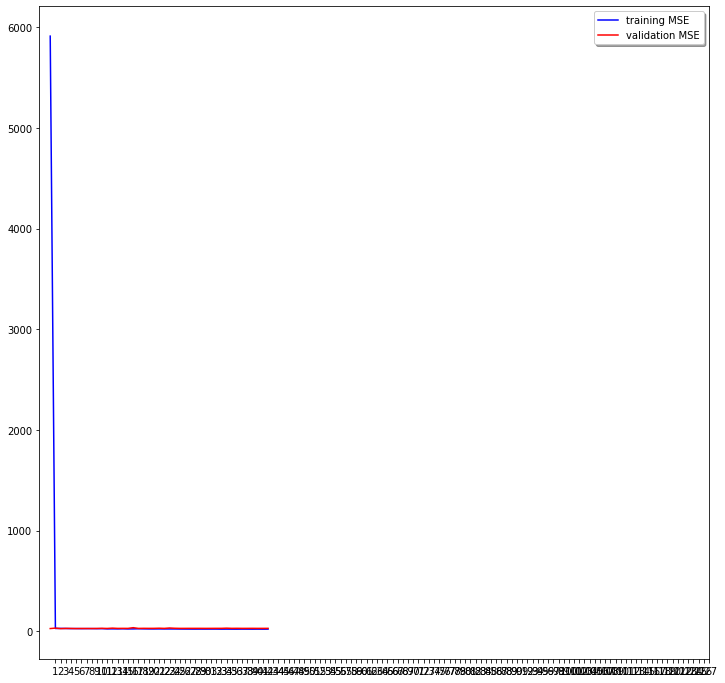

In [21]:
# Melakukan visualisasi nilai MSE pada data training dan testing.
fig, ax = plt.subplots(1, 1, figsize = (12, 12))
ax.plot(history.history['mse'], color='b', label = 'training MSE')
ax.plot(history.history['val_mse'], color='r', label = 'validation MSE')
ax.set_xticks(np.arange(1, epochs, 1))
legend = plt.legend(loc = 'best', shadow = True)
plt.show()

In [22]:
# Menyusun rekam jejak model berdasarkan nilai MSE pada setiap epoch, diurutkan dari yang terbaik.
history_df = pd.DataFrame(history.history).sort_values('val_mse').reset_index()
history_df.rename(columns = {'index': 'epoch'}, inplace = True)
history_df.to_csv('history_{}.csv'.format(codename), index = False)
history_df

,epoch,loss,mse,val_loss,val_mse,lr
0,2,29.398306,29.398285,27.227404,27.227379,0.031852
1,5,27.828239,27.828220,27.879478,27.879450,0.031852
2,0,5910.513184,5910.513184,27.931767,27.931740,0.031852
3,8,27.357334,27.357319,28.381067,28.381046,0.031852
4,7,27.327631,27.327610,28.504025,28.504002,0.031852
5,6,26.894548,26.894533,28.829845,28.829821,0.031852
6,9,26.630066,26.630039,28.983091,28.983061,0.031852
7,11,24.627363,24.627323,29.035677,29.035652,0.015926
8,4,27.440033,27.440004,29.042770,29.042744,0.031852
9,3,28.598036,28.598013,29.285194,29.285173,0.031852


In [23]:
# Menyimpan nilai prediksi validasi dan testing diurutkan berdasarkan nilai validasi MSE terbaik.
best_valid_preds = pd.DataFrame()
best_test_preds = pd.DataFrame()

for temp_index in list(history_df.iloc[:, 0]):
    temp_df_valid = pd.read_csv('./valid_preds_{}.csv'.format(temp_index))
    temp_df_test = pd.read_csv('./test_preds_{}.csv'.format(temp_index))
    best_valid_preds = pd.concat([best_valid_preds, temp_df_valid], axis = 1, ignore_index = True)
    best_test_preds = pd.concat([best_test_preds, temp_df_test], axis = 1, ignore_index = True)

best_valid_preds.to_csv('valid_preds_{}.csv'.format(codename), index = False)
best_test_preds.to_csv('test_preds_{}.csv'.format(codename), index = False)

In [24]:
# Membuang file yang sudah tidak diperlukan.
for temp_index in list(history_df.iloc[:, 0]):
    os.remove('./valid_preds_{}.csv'.format(temp_index))
    os.remove('./test_preds_{}.csv'.format(temp_index))

In [25]:
# Menampilkan prediksi data validasi diurutkan berdasarkan nilai validasi MSE terbaik.
best_valid_preds

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,27.637604,28.117357,26.004679,27.655016,28.665780,27.519726,30.071318,28.924578,27.897972,29.341675,...,29.718182,29.973950,29.467155,27.726460,27.422060,30.153042,30.834421,28.337545,30.745184,26.601946
1,26.688211,26.426899,26.111639,25.761957,25.223494,25.260588,25.967344,25.543987,24.172924,27.380220,...,26.771608,25.785257,26.938179,25.003088,24.394222,27.756042,27.120502,27.664284,27.801070,23.039782
2,28.310623,27.909264,26.862146,26.969212,27.676025,27.755926,28.543736,27.727266,27.057482,29.094389,...,28.894686,29.133940,29.601313,27.946877,27.617220,30.430000,29.964441,29.056028,30.975372,26.080479
3,26.071915,26.555843,26.429771,26.234629,25.023033,24.855778,26.890554,26.102520,24.713118,26.597990,...,27.659143,26.559692,26.782053,25.282887,25.081484,27.835110,28.070595,27.726720,28.645582,24.096401
4,25.591867,24.890882,26.431067,24.276987,22.885195,23.993977,24.476284,23.656921,23.548700,26.112106,...,24.908169,23.567759,23.166605,22.439762,22.371180,24.353514,24.948156,27.860880,25.308973,20.850916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,27.199207,27.046242,26.757582,27.105196,27.115826,25.969442,28.049020,27.115091,26.137133,28.452415,...,28.096720,27.651144,28.250656,26.257530,26.364439,29.251890,29.053074,28.894728,29.497019,24.807331
457,26.465351,25.526050,26.318027,25.149324,25.419890,24.931023,26.137100,25.582771,25.106047,27.505249,...,26.503153,24.569300,24.188778,22.952110,22.655663,25.361902,26.858742,28.007309,25.881308,21.904520
458,28.086267,27.605988,27.132082,27.589708,27.655561,27.856623,28.656034,28.212324,27.602068,30.007603,...,29.145819,28.881603,28.533972,27.083721,27.002108,29.458176,30.386208,29.723207,30.233156,26.146114
459,26.942587,27.931377,26.595820,29.061728,28.250883,27.604996,29.267874,29.006062,26.128918,28.604803,...,30.197302,29.729044,29.367842,28.080463,27.538868,30.195920,31.141127,28.434996,31.153177,26.798021


In [26]:
# Menampilkan prediksi data testing diurutkan berdasarkan nilai validasi MSE terbaik.
best_test_preds

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,26.341003,26.656830,26.352552,25.491250,24.819984,24.827883,25.827549,24.683477,24.523853,27.709467,...,26.509752,23.898682,23.211130,21.625038,22.033453,24.113054,26.333778,28.235796,24.908257,20.624952
1,27.881073,27.993652,26.099710,27.935818,27.565756,26.752098,29.119207,28.774595,27.237530,28.858723,...,29.536540,29.410208,29.846620,27.975157,27.681910,30.598830,30.957146,27.624504,30.912327,26.412512
2,27.414585,27.126595,26.828447,26.385307,25.922752,26.600958,26.962290,26.229030,26.019272,28.679815,...,27.617813,27.505373,26.628490,25.453218,25.478966,27.470240,28.148418,29.334232,28.301601,23.627237
3,26.745600,26.774225,26.553062,26.910463,26.352129,25.544851,27.169287,26.221462,25.431541,28.292162,...,27.375883,26.176968,26.735678,24.759596,24.792559,27.608810,28.038498,29.231600,28.211113,23.501852
4,26.757060,27.358963,26.543670,27.177164,26.990850,26.231775,28.325802,27.858091,26.216870,28.708954,...,28.719084,29.340620,29.888842,28.091690,27.664377,30.876875,29.685616,28.151577,31.054663,25.942402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,27.378551,27.368256,25.883772,26.820885,28.309027,26.881363,28.053282,27.374329,26.418747,28.780844,...,28.681063,28.975096,28.900429,26.829094,26.539215,29.751904,30.078802,28.581896,29.628237,25.482264
986,26.091764,27.820053,26.023531,27.598866,26.967910,26.393850,27.513660,27.002909,24.473782,26.639906,...,28.973751,28.909100,29.704836,27.409475,27.056643,30.415117,29.427864,27.950512,30.535990,25.054483
987,26.751791,26.026066,26.021450,25.398706,24.784103,25.140700,26.575949,25.913294,25.060284,27.574995,...,27.340546,25.085630,26.068258,24.072630,24.105015,27.000053,27.767477,27.536013,27.078135,23.124800
988,23.654373,24.116120,26.192616,23.795700,22.163174,21.682087,24.051205,23.334803,21.334528,24.451176,...,25.224850,23.427877,23.462593,22.515871,22.316580,24.643505,24.665611,26.606518,25.806068,21.112024


In [27]:
# Menampilkan nilai MSE terbaik pada data validasi.
error = MSE(y_valid, best_valid_preds[0])
print('nilai MSE pada data validasi: ', error)

nilai MSE pada data validasi:  27.22737827214936


In [28]:
# Mencatat waktu berakhirnya keseluruhan program model dan prediksi data.
global_end_time = time.time()

# Menampilkan waktu eksekusi dari keseluruhan program model dan prediksi data.
total_execution_time = datetime.timedelta(seconds = global_end_time - global_start_time)
print("total execution time: %s" % (total_execution_time))

total execution time: 0:19:35.858455
